# Download dataset & install dependencies.

We'll Use Shanghaitech dataset. For downloading dataset you need kaggle account and kaggle api token credentials. You can download credentials from your account page of your kaggle account.

In [ ]:
!pip install -q git+https://github.com/albumentations-team/albumentations
!pip install -U -q scipy

In [ ]:
# Upload kaggle.json for downloading dataset
from google.colab import files
files.upload()

In [3]:
# copy kaggle.json to ~/.kaggle/kaggle.json
# change permission to 600
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download shanghaitech from kaggle
!kaggle datasets download -d tthien/shanghaitech

In [5]:
# extract dataset
!unzip -q -o ./shanghaitech.zip

# ShanghaiTech Dataset

* ShanghaiTech dataset has two parts A and B. 
* Part A contains dense crowd while part B contains relatively sparse crowd.
* We'll use part A.

```
part_A
--train_data
  |--images
  |--ground-truth
--test_data
  |--images
  |--ground-truth
```

* Images are in jpg and have variable resolution
* Ground truth are mat files. It contains coordinates of centroid of human head.

In [6]:
import matplotlib.pyplot as plt

# set default figsize in matplotlib
plt.rcParams['figure.figsize'] = (10, 10)

In [7]:
import cv2
import matplotlib.pyplot as plt

def show_image(image, ax=None):
  """
  shows opencv BGR image on ax.
  uses current axis of ax is None.
  """
  if ax is None:
    ax = plt.gca()
  ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def show_torch_im(im, ax=None):
  """
  shows pytorch im of shape(c, h, w) on ax
  if ax is none it use current axis
  """
  if ax is None:
    ax = plt.gca()
  im = im.permute(1, 2, 0)
  ax.imshow(im)

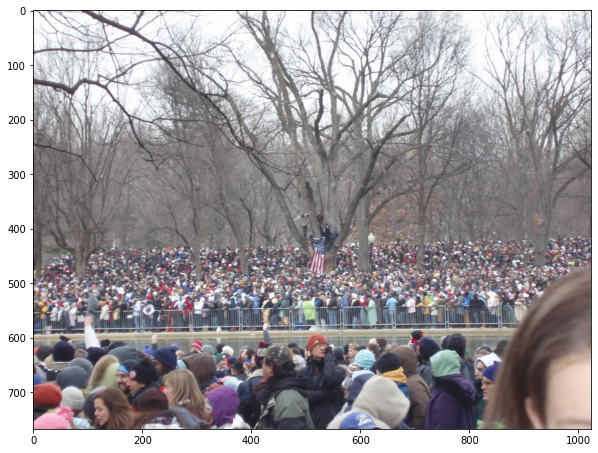

In [8]:
# sample image from dataset
img_path = './ShanghaiTech/part_A/train_data/images/IMG_1.jpg'
img = cv2.imread(img_path)

show_image(img)

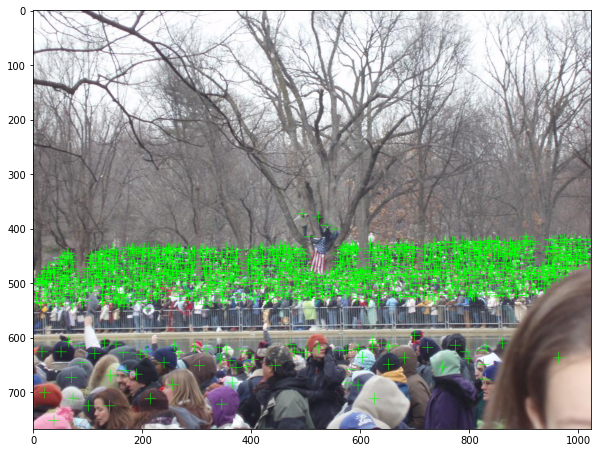

In [9]:
from scipy.io import loadmat

# read gt matlab file
gt_path = './ShanghaiTech/part_A/train_data/ground-truth/GT_IMG_1.mat'
gt_mat = loadmat(gt_path)

# extract points
gt_points = gt_mat['image_info'][0][0][0][0][0]

img2 = img.copy()

# draw each point
for point in gt_points:
  # points are 1 indexed
  x = int(point[0]-1)
  y = int(point[1]-1)
  cv2.drawMarker(img2, (x, y), (0, 255, 0))

# visualize
show_image(img2)

# Density Map

We'll create density map for each image in dataset. There are several ways to create density map.

Fixed Gaussian Kernel Algorithm
* create binary image same size as image with ones at location of each person's head centroid.
* apply gaussian filter to binary image.

KNN Based Gaussian kernel Algorithm
* its almost same as above algorithm.
* but different kernel is used for each pixel of image
* the standard deviation sigma used for generating kernel is calculated for each pixel based on average distance to other heads.

Note:
* The method you choose for density map generation will affect quality of your model, blurred images are easier for model to predict, but more blurring will reduce the headcount.

# Density Map to Head Count
* head_count = np.sum(density_map)

In [10]:
import cv2
import numpy as np
import math
from scipy import spatial
from scipy import ndimage
import time
import matplotlib.pyplot as plt

def density_fixed(shape, points, sigma=4.0):
    """
    creates density map with fixed gaussian kernel.
    """
    # matlab one indexed points
    points = [[int(p[0] -1), int(p[1] -1)] for p in points]

    h, w = shape[:2]

    density = np.zeros(shape, dtype=np.float32)

    if len(points) == 0:
        return density
    
    for point in points:
        x, y = math.floor(point[0]), math.floor(point[1])
        x, y = np.clip(x, 0, w - 1), np.clip(y, 0, h - 1)
        x, y = int(x), int(y)
        density[y, x] = 1

    return ndimage.filters.gaussian_filter(density, 
                                   sigma, 
                                   mode='constant')

def density_adaptive(shape, points, k=4, beta=0.3, leafsize=2048, truncate=4.0, use_cv=True):
    """
    creates density map with different gaussian kernel for each point.
    gaussian kernel standard deviation calculated based between points
    and its nearest neighbors.
    """
    # matlab one indexed points
    points = [[int(p[0] -1), int(p[1] -1)] for p in points]

    h, w = shape[:2]

    density = np.zeros(shape, dtype=np.float32)

    if len(points) == 0:
        return density
    
    if len(points) > 1:
        tree = spatial.KDTree(points.copy(), leafsize=leafsize)
        distances, _ = tree.query(points, k=4)
    
    sigma = np.average(np.array(shape))/2./2.

    for i, point in enumerate(points):

        # single point uses default sigma
        if len(points) > 1:
            sigma = np.sum(distances[i, 1:k])

        # scipy.ndimage.gaussian_filter sets
        # kernel_size to this value
        kernel_size = int(truncate * sigma + 0.5)
        if kernel_size % 2 == 0:
            kernel_size += 1

        # Our image has only one pixel that is white.
        # Only those pixels that are within window size will be
        # effected by the kernel.
        window_size = int(kernel_size + ((kernel_size // 2) * 2))
        window = np.zeros((window_size, window_size), dtype='float32')
        window[window_size // 2, window_size // 2] = 1
        
        # blur window
        if use_cv:
            window = cv2.GaussianBlur(window,
                                      (kernel_size, kernel_size),
                                      sigma, 
                                      sigma,  
                                      cv2.BORDER_CONSTANT)
        else:
            window = ndimage.filters.gaussian_filter(window,
                                                     sigma, 
                                                     mode='constant', 
                                                     truncate=truncate)
        

        # bounds of density map and window
        density_coords, window_coords = get_overlap_coords(point, shape, window_size)

        x1, y1, x2, y2 = density_coords
        wx1, wy1, wx2, wy2 = window_coords

        # add blurred window to the density map
        density[y1:y2, x1:x2] += window[wy1:wy2, wx1:wx2]
    return density

def get_overlap_coords(point, img_shape, window_size):
    """
    Calculates bounds of window and image.
    Window is overlaid on the image such that
    the center of the window is on top of
    point in the image.
    """
    h, w = img_shape[:2]

    # x and y coordinates of point
    x, y = math.floor(point[0]), math.floor(point[1])
    x, y = np.clip(x, 0, w - 1), np.clip(y, 0, h - 1)
    x, y = int(x), int(y)
    
    # minx, miny, maxx, maxy coordinates of window
    wx1, wy1, wx2, wy2 = 0, 0, window_size - 1, window_size - 1
    
    # minx, miny, maxx, maxy coordinates of density map
    x1, y1 = x - (window_size // 2), y - (window_size // 2)
    x2, y2 = x + (window_size // 2), y + (window_size // 2)

    # minx out of bounds
    if x1 < 0:
        d = abs(x1)
        x1, wx1 = 0, wx1 + d

    # miny out of bounds
    if y1 < 0:
        d = abs(y1)
        y1, wy1 = 0, wy1 + d

    # maxx out of bounds
    if x2 > w:
        d = x2-w
        x2, wx2 = w, wx2 - abs(d)

    # maxy out of bounds
    if y2 > h:
        d = y2-h
        y2, wy2 = h, wy2 - abs(d)

    return [x1, y1, x2, y2], [wx1, wy1, wx2, wy2]

In [11]:
def visualize_density(img, dmap):
    _, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs = axs.ravel()
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[1].imshow(dmap, cmap='jet')

Density Fixed
Time | 0.20854926109313965 seconds
Head Count | actual 1546 density 1535


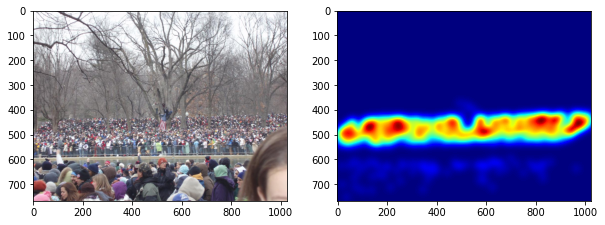

In [12]:
print("Density Fixed")

start_time = time.time()
density = density_fixed(img.shape[:2], gt_points, sigma=16)

print(f"Time | {time.time() - start_time} seconds")
print(f"Head Count | actual {len(gt_points)} density {int(np.sum(density))}")

visualize_density(img, density)

Density Adaptive Scipy
Time | 12.428968667984009 seconds
Head Count | actual 1546 density 1507


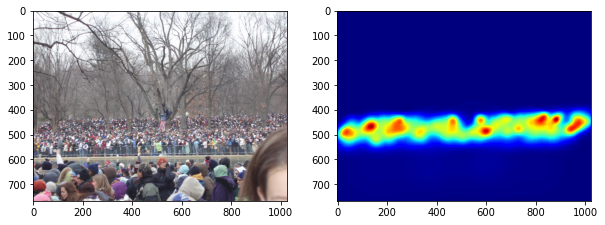

In [13]:
print("Density Adaptive Scipy")

start_time = time.time()
density = density_adaptive(img.shape[:2], gt_points, truncate=2.0, use_cv=False)

print(f"Time | {time.time() - start_time} seconds")
print(f"Head Count | actual {len(gt_points)} density {int(np.sum(density))}")

visualize_density(img, density)

Density Adaptive Opencv
Time | 2.0205209255218506 seconds
Head Count | actual 1546 density 1534


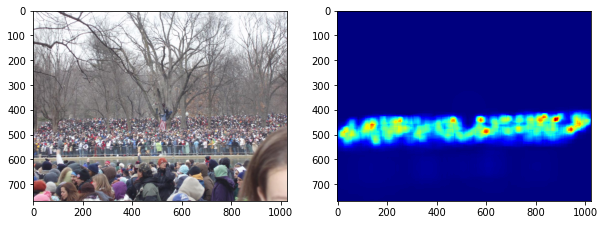

In [14]:
print("Density Adaptive Opencv")

start_time = time.time()
density = density_adaptive(img.shape[:2], gt_points, truncate=2.0, use_cv=True)

print(f"Time | {time.time() - start_time} seconds")
print(f"Head Count | actual {len(gt_points)} density {int(np.sum(density))}")

visualize_density(img, density)

# Preprocess Data

* Generate density map for train, and test set.
* Split data into train, val, test sets.


In [15]:
!rm -r ./ShanghaiTech
!unzip -q -o ./shanghaitech.zip

In [16]:
import numpy as np
from scipy import spatial
from scipy import ndimage
from scipy.io import loadmat
import scipy
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split
import math

ROOT = './ShanghaiTech/part_A'
SEED = 42
VAL_SIZE = 0.2 # size of validation data

DENSITY = 'fixed' # one of fixed, adaptive_cv, adaptive_scipy
sigma = 16.0
truncate = 2.0

# select density calculation method
if DENSITY == 'fixed':
    def gen_density_map(shape, points):
        return density_fixed(shape, points, sigma=sigma)
elif DENSITY == 'adaptive_cv':
    def gen_density_map(shape, points):
        return density_adaptive(shape, points, truncate=truncate, use_cv=True)
else:
    def gen_density_map(shape, points):
        return density_adaptive(shape, points, truncate=truncate, use_cv=False)

def get_data(images_dir, density_dir):
    """
    returns path of images and gts
    """
    imgs = [img for img in os.listdir(images_dir) if img[-3:].lower() == "jpg"]
    density = [img[:-3] + "npy" for img in imgs]
    imgs = [os.path.join(images_dir, img) for img in imgs]
    density = [os.path.join(density_dir, gt) for gt in density]
    return imgs, density

dirs = {
    'train': {
        'images': os.path.abspath(os.path.join(ROOT, 'train_data', 'images')),
        'gt': os.path.abspath(os.path.join(ROOT, 'train_data', 'ground-truth')),
        'density': os.path.abspath(os.path.join(ROOT, 'train_data', 'density')),
    },
    'val': {
        'images': os.path.abspath(os.path.join(ROOT, 'val_data', 'images')),
        'gt': os.path.abspath(os.path.join(ROOT, 'val_data', 'ground-truth')),
        'density': os.path.abspath(os.path.join(ROOT, 'val_data', 'density')),
    },
    'test': {
        'images': os.path.abspath(os.path.join(ROOT, 'test_data', 'images')),
        'gt': os.path.abspath(os.path.join(ROOT, 'test_data', 'ground-truth')),
        'density': os.path.abspath(os.path.join(ROOT, 'test_data', 'density')),
    },
}

# make all directories
for split in dirs.keys():
  for folder in dirs[split].keys():
    os.makedirs(dirs[split][folder], exist_ok=True)

np.random.seed(SEED)

# generate density map and save
for split in ['train', 'test']:

    img_dir = dirs[split]['images']
    gt_dir = dirs[split]['gt']
    density_dir = dirs[split]['density']

    images = os.listdir(img_dir)

    print(f"Generating density map for {split} images...")
    for i, fname in enumerate(images):
        if (i+1) % 50 == 0: 
          print(f"{i+1}")
        # base name of image file
        mat_fname = fname.replace("IMG_", "GT_IMG_")[:-3] + "mat"
        density_fname = fname[:-3] + "npy"

        # path of density and mat file of gt
        img_path = os.path.join(img_dir, fname)
        density_path = os.path.join(density_dir, density_fname)
        mat_path = os.path.join(gt_dir, mat_fname)

        # load image and points
        img = cv2.imread(img_path)
        points = loadmat(mat_path)['image_info'][0][0][0][0][0]
 
        # generate and save density map image
        density = gen_density_map(img.shape[:2], points)
        np.save(density_path, density)
    print("")

# train test split
imgs, densities = get_data(dirs['train']['images'], dirs['train']['density'])
train_images, val_images, train_density, val_density = train_test_split(imgs,
                                                              densities,
                                                              test_size=VAL_SIZE,
                                                              random_state=SEED)

# move validation data to its directory
for im, density in zip(val_images, val_density):
    shutil.move(im, dirs['val']['images'])
    shutil.move(density, dirs['val']['density'])

Generating density map for train images...
50
100
150
200
250
300

Generating density map for test images...
50
100
150



# Create Pytorch Dataset
* create train, val, test data.
* apply necessary augmentations.

In [17]:
import os
from scipy.io import loadmat

ROOT_DIR = './ShanghaiTech/part_A/'

def get_data(split):
  """
  returns images_path and density map for split
  images are jpg and density maps are npy files (read with np.load function)
  """
  split_dir = os.path.join(ROOT_DIR, f"{split}_data")
  images_dir = os.path.join(split_dir, 'images')
  density_dir = os.path.join(split_dir, 'density')
  imgs = [img for img in os.listdir(images_dir) if img[-3:].lower() == "jpg"]
  density = [img[:-3] + "npy" for img in imgs]
  imgs = [os.path.join(images_dir, img) for img in imgs]
  density = [os.path.join(density_dir, d) for d in density]
  return imgs, density

In [18]:
train_images, train_density = get_data('train')
val_images, val_density = get_data('val')
test_images, test_density = get_data('test')

In [19]:
print("train samples", len(train_images))
print("val samples", len(val_images))
print("test samples", len(test_images))
print("sample", train_images[0], train_density[0])

train samples 240
val samples 60
test samples 182
sample ./ShanghaiTech/part_A/train_data/images/IMG_274.jpg ./ShanghaiTech/part_A/train_data/density/IMG_274.npy


In [20]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
import albumentations.augmentations.crops.functional as AF
import numpy as np
import math

# IMPORTANT 
# Last transform must be ToTensorV2(transpose_mask=True),
# which gives image of shape (c, h, w) which is required
# by the model.

class RatioCrop(DualTransform):
    """Randomly crops image, cropped image width & height
    will be between ratio_min, ratio_max of original image
    Args:
        ratio_min (float): min size of cropped image in percentage between 0 and 1
        ratio_max (float): max size of cropped image in percentage between 0 and 1
        p (float): probability of applying the transform. Default: 1.
    Targets:
        image, mask, bboxes, keypoints
    Image types:
        uint8, float32
    """

    def __init__(self, ratio_min, ratio_max, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.ratio_min = ratio_min
        self.ratio_max = ratio_max

    def apply(self, img, h_start=0, w_start=0, **params):
        height, width = self.get_hw(**params)
        img = AF.random_crop(img, height, width, h_start, w_start)
        return img
    
    def apply_to_mask(self, img, h_start=0, w_start=0, **params):
      height, width = self.get_hw(**params)
      img = AF.random_crop(img, height, width, h_start, w_start)
      return img

    def apply_to_bbox(self, bbox, **params):
        height, width = self.get_hw(**params)
        return AF.bbox_random_crop(bbox, height, width, **params)

    def apply_to_keypoint(self, keypoint, **params):
        height, width = self.get_hw(**params)
        return AF.keypoint_random_crop(keypoint, height, width, **params)

    def get_hw(self, **params):
      h = math.floor(params['cols'] * params['ratio'])
      w = math.floor(params['rows'] * params['ratio'])
      return h, w


    def get_transform_init_args_names(self):
        return ("ratio_min", "ratio_max")
    
    def get_params(self):
        return {}
    
    def update_params(self, params, **kwargs):
      cols, rows = kwargs["image"].shape[:2]
      
      range = (self.ratio_max - self.ratio_min)
      ratio = (np.random.random() * range) + self.ratio_min
      ratio = np.clip(ratio, self.ratio_min, self.ratio_max)

      h_max = (1 - ratio)
      w_max = (1 - ratio)

      h_start = np.random.random() * h_max
      w_start = np.random.random() * w_max

      params.update({
          "h_start": h_start,
          "w_start": w_start,
          "cols": cols,
          "rows": rows,
          "ratio": ratio,
      })
      return params

transforms = {
    'train': A.Compose([
        # RatioCrop(ratio_min=0.5, ratio_max=0.5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1),
        ToTensorV2(always_apply=True, p=1.0, transpose_mask=True), # (c, h, w)
    ]),

    'val': A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1),
        ToTensorV2(always_apply=True, p=1.0, transpose_mask=True), # (c, h, w)
    ]),

    'test': A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], p=1),
        ToTensorV2(always_apply=True, p=1.0, transpose_mask=True), # (c, h, w)
    ]),
}

In [21]:
import torch
import numpy
import cv2
from scipy.io import loadmat
import os
import re
from scipy.ndimage import gaussian_filter

class ShanghaiTechDataset(object):
  """
  ShanghaiTech Dataset

  Args:
    images: list of full path of images
    density: list of full path of density map .npy files  
    upsample: upsamples the dataset by factor
    transforms: albumentations transforms, last transform must be ToTensorV2 with mask_transpose set to True.
    downscale (int): density map will be downscaled by this number
  """

  def __init__(self, images, density, transforms, upsample=1, downscale=4):
    self.images = images
    self.density = density
    self.transforms = transforms
    self.downscale = downscale
    self.upsample = upsample

  def __len__(self):
    return len(self.images) * self.upsample

  def __getitem__(self, index):
    index = index % len(self.images)

    # img
    # shape: (h, w, 3)
    # dtype: (float32)
    img = cv2.imread(self.images[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32')
    
    # dmap
    # shape: (h, w)
    # dtype: float32
    dmap = np.load(self.density[index])

    # apply transforms
    transformed = self.transforms(image=img, mask=dmap)

    # img
    # shape: (c, h, w)
    # dtype: float32
    img = transformed['image']

    # dmap
    # shape: (h, w)
    # dtype: float32
    dmap = transformed['mask']
    dmap = dmap.numpy()

    # downscale dmap by scale factor
    # cols, rows
    new_shape = (dmap.shape[1] // self.downscale, 
                 dmap.shape[0] // self.downscale)
    dmap = cv2.resize(dmap, new_shape, interpolation=cv2.INTER_CUBIC)

    # Multiply density map by downscale^2
    # to compensate for downscaling.
    # 
    # Head count is sum of each pixel in density map
    # Since we downscaled the density map by factor f
    # number of pixels decreased by f^2. Thus head count
    # also decreased by f^2.
    # 
    # For example if head count was 256 and
    # we resized image to 1/4 th. Then head
    # count of new image is 256/(4*4)=16.
    dmap *= (self.downscale**2)

    # convert dmap to torch tensor
    dmap = torch.tensor(dmap, dtype=torch.float32)

    # img: (3, h, w) float32
    return img, dmap

In [22]:
downscale = 8
upsample = 4

train_ds = ShanghaiTechDataset(train_images, train_density, 
                               transforms['train'], 
                               upsample=upsample, 
                               downscale=downscale)

val_ds = ShanghaiTechDataset(val_images, val_density, 
                             transforms['val'], 
                             downscale=downscale)

test_ds = ShanghaiTechDataset(test_images, test_density, 
                              transforms['test'], 
                              downscale=downscale)

In [23]:
# print shapes to check if dataset is working as expected
im, dmap = train_ds[0]

# img is tensor
print("img shape", im.size())

# dmap is tensor
print("dmap shape", dmap.size())

# assert
assert dmap.size()[0] == im.size()[1] // downscale, "generated density map has wrong height"
assert dmap.size()[1] == im.size()[2] // downscale, "generated density map has wrong width"

img shape torch.Size([3, 681, 1024])
dmap shape torch.Size([85, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


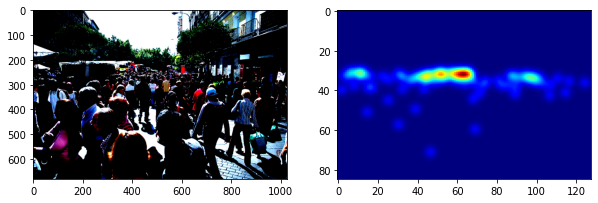

In [24]:
# plot image and density map
# to see if they are correct

# create matplotlib axis
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# show image
show_torch_im(im, ax1)

# show density map
ax2.imshow(dmap, cmap='jet');

ax1.set_aspect(1)
ax2.set_aspect(1)

# Explore dataset

In [25]:
def visualize_dataset(dataset, n=5):
  fig, axs = plt.subplots(nrows=n, ncols=2, figsize=(10, 4*n))
  axs = axs.ravel()

  # random_indices = np.random.choice(list(range(len(dataset))), n)
  random_indices = []
  random_index = -1

  for i in range(n):
    while random_index in random_indices or random_index == -1:
      random_index = np.random.randint(0, len(dataset)+1)
    random_indices.append(random_index)

    image, dmap = dataset[random_index]

    ax1 = axs[i*2]
    ax2 = axs[i*2 + 1]

    head_count = torch.sum(dmap)

    ax1.imshow(image.permute(1, 2, 0).clip(0, 1))
    ax2.imshow(dmap.clip(0, 1), cmap='jet')
  
    ax1.set_aspect(1)
    ax1.set_axis_off()
    ax2.set_aspect(1)
    ax2.set_axis_off()

    ax2.set_title(f'Head Count {head_count}')

  # plt.subplots_adjust(wspace=0, hspace=0)

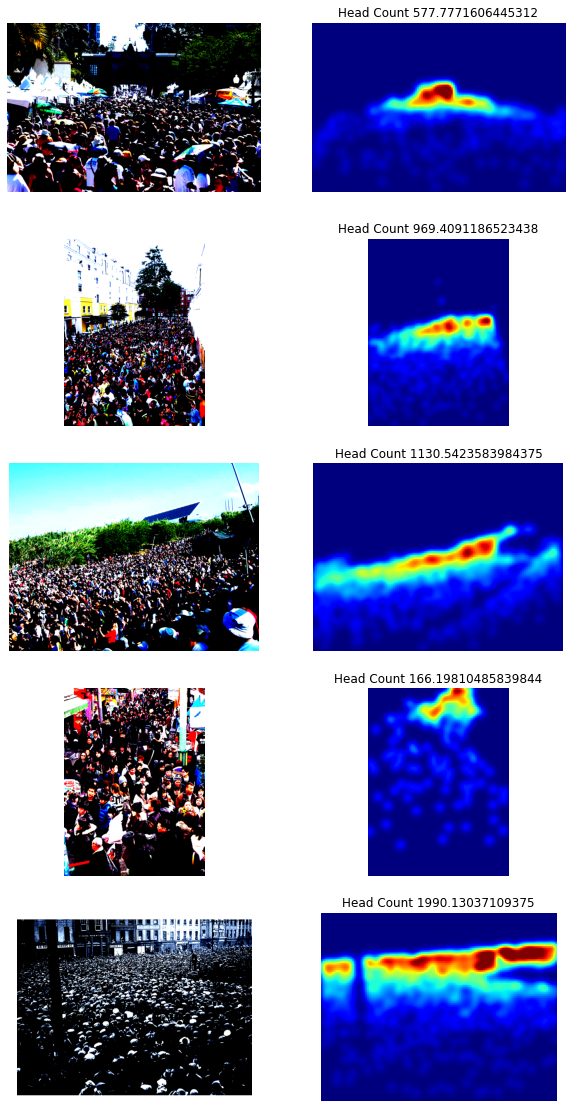

In [26]:
# train dataset
visualize_dataset(train_ds, 5)

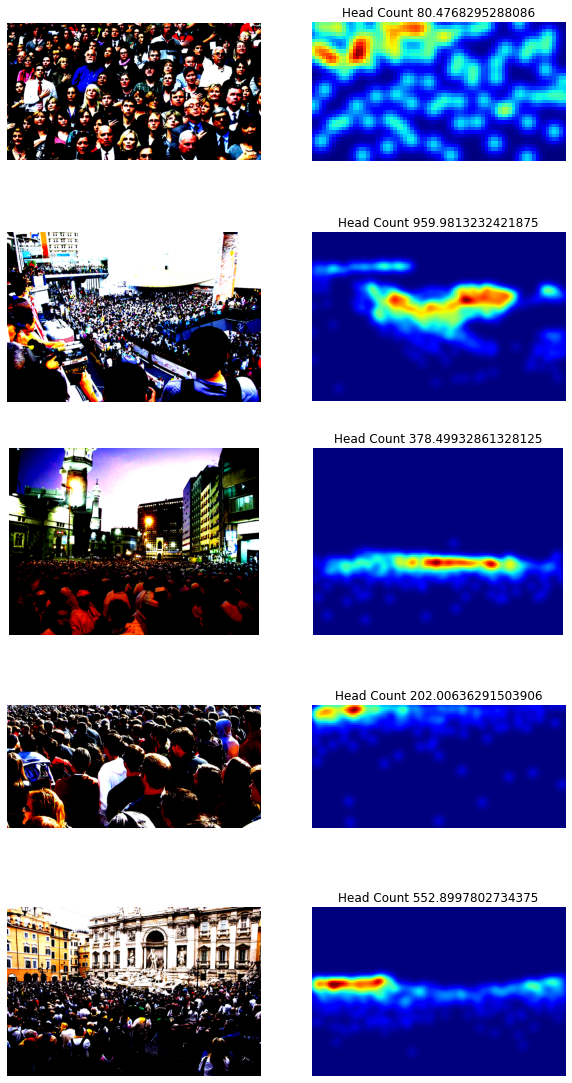

In [27]:
# validation dataset
visualize_dataset(val_ds, 5)

In [28]:
# function to get head counts of dataset
def get_headcounts(dataset):
  head_counts = []
  for i in range(len(dataset)):
    _, dmap = dataset[i]
    head_count = int(torch.sum(dmap))
    head_counts.append(head_count)

  return head_counts

def get_zero_headcounts(counts):
  return len([c for c in counts if c == 0])

In [29]:
train_headcounts = get_headcounts(train_ds)
val_headcounts = get_headcounts(val_ds)
test_headcounts = get_headcounts(test_ds)

In [30]:
print("train zero headcounts", get_zero_headcounts(train_headcounts))
print("val zero headcounts", get_zero_headcounts(val_headcounts))
print("test zero headcounts", get_zero_headcounts(test_headcounts))

train zero headcounts 0
val zero headcounts 0
test zero headcounts 0


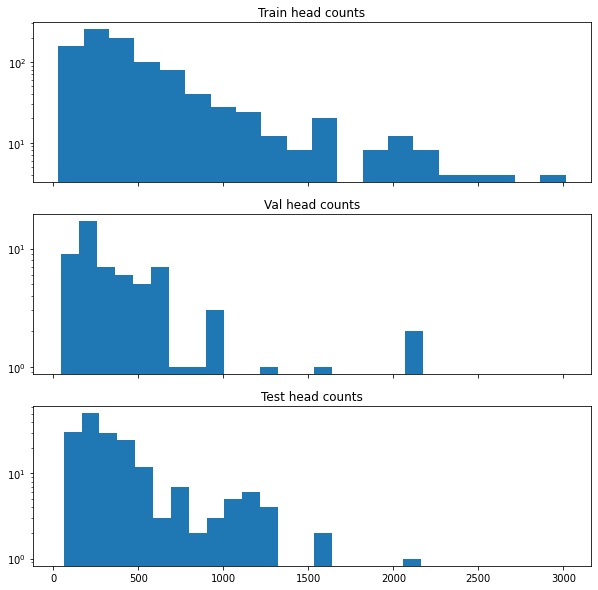

In [31]:
bins = 20

_, axs = plt.subplots(3, 1, sharex=True, sharey=False)
axs = axs.ravel()

axs[0].hist(train_headcounts, bins=bins, log=True)
axs[0].set_title('Train head counts')

axs[1].hist(val_headcounts, bins=bins, log=True)
axs[1].set_title('Val head counts')

axs[2].hist(test_headcounts, bins=bins, log=True)
axs[2].set_title('Test head counts');

# Create Pytorch Dataloader

In [32]:
import torch

# We'll create helper functions that help use load
# data to cuda GPU.

# use cuda if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def to_device(data, device):
  """
  loads data onto device
  """
  if isinstance(data, (list, tuple)):
    return [to_device(d, device) for d in data]
  if isinstance(data, dict):
    return {k: to_device(v, device) for (k, v) in data.items()}
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    """
    wraps a pytorch dataloader
    for each batch that dataloader yields
    it loads that batch onto device
    """
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for data in self.dl:
      yield to_device(data, self.device)

  def __len__(self):
    return len(self.dl)

In [33]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
WORKERS = 2

# train dataloader
train_dl = DeviceDataLoader(
    DataLoader(train_ds,
               batch_size=BATCH_SIZE,
               shuffle=True,
               pin_memory=False,
               num_workers=WORKERS),
    device,
)

# val dataloader
val_dl = DeviceDataLoader(
    DataLoader(val_ds,
               batch_size=BATCH_SIZE,
               pin_memory=False),
    device,
)

# test dataloader
test_dl = DeviceDataLoader(
    DataLoader(test_ds,
               batch_size=BATCH_SIZE,
               pin_memory=False),
    device,
)

In [34]:
# look at val_dl output
for imgs, dmaps in val_dl:
  # imgs, dmaps is tensor
  print("imgs size", imgs.size())
  print("dmaps size", dmaps.size())
  break

imgs size torch.Size([1, 3, 686, 1024])
dmaps size torch.Size([1, 85, 128])


# Create model

In [35]:
from torch import nn
import torch.nn.functional as F
from torch import nn
import torch
import torchvision

class CSRNet(nn.Module):
  """
  CSRNet B as described in CSRNet: Dilated Convolutional Neural Networks for Understanding the HighlyCongested Scenes
  by Yuhong Li et al. (https://arxiv.org/pdf/1802.10062.pdf).
  """
  def __init__(self, pretrained_vgg=True):
    super().__init__()

    self.frontend_config = [64, 64, 'M', 
                            128, 128, 'M', 
                            256, 256, 256, 'M', 
                            512, 512, 512]

    self.backend_config = [512, 512, 512, 256, 128, 64]

    self.frontend = self._make_layer(self.frontend_config, 
                                     in_channels=3)

    self.backend = self._make_layer(self.backend_config, 
                                    in_channels=512, 
                                    dilation=2)

    self.output = nn.Conv2d(64, 1, 1)

    self._initalize_weights()
    if pretrained_vgg:
      self._load_vgg_weights()

  def forward(self, images):
    # input  (b, c, h, w)
    # output (b, 512, h/8, w/8)
    x = self.frontend(images)

    # input  (b, 512, h/8, w/8)
    # output (b, 64, h/8, w/8)
    x = self.backend(x)

    # input  (b, 64, h/8, w/8)
    # output (b, 1, h/8, w/8)
    x = self.output(x)

    # input  (b, 1, h/8, w/8)
    # output (b, h/8, w/8)
    x = torch.squeeze(x, dim=1)

    return x

  def _load_vgg_weights(self):
    vgg = torchvision.models.vgg16(pretrained = True)
    for i in range(len(self.frontend.state_dict().items())):
      list(self.frontend.state_dict().items())[i][1].data[:] = list(vgg.state_dict().items())[i][1].data[:]

  def _initalize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, std=0.01)
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

  def _make_layer(self, config, in_channels, dilation=1, batch_norm=False):
    layers = []
    for val in config:
      if val == 'M':
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
      else:
        out_channels = val
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                         padding=dilation, dilation=dilation)
        layers.append(conv)
        if batch_norm:
          layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        in_channels = val
    return nn.Sequential(*layers)


In [36]:
# create model
model = CSRNet()
model = to_device(model, device)

# get batch of data
imgs, dmaps = next(iter(train_dl))

# pass data to model
out = model(imgs)

# check model output size equals dmaps size
print("model output    size", out.size())
print("dmaps size", dmaps.size())

# head count
print("predicted head count", torch.sum(out).item())
print("actual head count   ", torch.sum(dmaps).item())

# assert correct size
assert dmaps.size() == out.size(), "model output shape must be equal to denstity map shape returned by dataloader"

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



model output    size torch.Size([1, 85, 128])
dmaps size torch.Size([1, 85, 128])
predicted head count -5.542392730712891
actual head count    287.7182312011719


# Loss function and evaluation metrics

* For loss fuction we'll use MSELoss.
* For evaulation we'll use RMSE and MAE. For head count produced by density map.
* Since we're interested in dense crowd RMSE is more important metric for us.

In [37]:
from torch.nn import MSELoss

# loss function
loss_fn = MSELoss(reduction='sum')

# mae
def mae(y, ypred):
  return torch.abs(torch.sum(y) - torch.sum(ypred)) / len(y)

# rmse
def rmse(y, ypred):
  return torch.sqrt(((torch.sum(y) - torch.sum(ypred))**2) / len(y))

In [38]:
print('loss', loss_fn(dmaps, out).item())
print('rmse', rmse(dmaps, out).item())
print('mae ', mae(dmaps, out).item())

loss 11.312864303588867
rmse 293.2606201171875
mae  293.2606201171875


# Training Helpers

In [39]:
from torchvision.utils import make_grid

def visualize_pred(img, dmap, pred):
  img = torch.clip(img.squeeze(0).detach().cpu(), 0, 1)
  dmap = torch.clip(dmap.squeeze(0).detach().cpu(), 0, 1)
  pred = torch.clip(pred.squeeze(0).detach().cpu(), 0, 1)
  fig, axs = plt.subplots(1, 3, figsize=(10, 5))
  axs = axs.ravel()
  axs[0].imshow(img.permute(1, 2, 0))
  axs[2].imshow(dmap)
  axs[1].imshow(pred)
  axs[0].set_axis_off()
  axs[1].set_axis_off()
  axs[2].set_axis_off()
  return fig

In [40]:
def train_for_epoch(model, dataloader, optimizer, loss_fn, epoch, log=False, scheduler=None, writer=None):
  """
  trains model for one epoch
  return (loss, metrics)
  where metrics is dictionary containing rmse and mae.
  """

  # loss and metrics for epoch
  total_loss = 0
  total_samples = 0
  total_rmse = 0
  total_mae = 0

  steps_per_epoch = len(dataloader)

  # train batch using gradient descent
  for i, batch in enumerate(dataloader):
    xb, yb = batch

    # zero gradients
    model.train()
    optimizer.zero_grad()

    # forward
    ypred = model(xb)

    # calculate loss
    loss = loss_fn(yb, ypred)

    # backward
    loss.backward()

    # update weights
    optimizer.step()

    if scheduler is not None:
      scheduler.step()

    with torch.no_grad():
      if i % 100 == 0 and writer is not None:
        step = (epoch * steps_per_epoch) + (i+1)
        fig = visualize_pred(xb, yb, ypred)
        writer.add_figure('density map pred vs acutal', fig, step)
        writer.flush()

      # headcount
      actual_headcount = torch.sum(ypred).item()
      pred_headcount = torch.sum(yb).item()

      # calculate metrics for this batch
      batch_samples = len(xb)
      batch_rmse = (actual_headcount - pred_headcount) ** 2 
      batch_mae = abs(actual_headcount - pred_headcount)

      # update epoch loss and metrics
      total_samples += batch_samples
      total_loss += loss
      total_rmse += batch_rmse
      total_mae += batch_mae

      if i % 10 == 0 and log:
        print(f"Batch [{i}] train | loss: {loss:.6f} mae: {(batch_mae/batch_samples):.4f}")


  # divide by total number of samples
  total_loss = total_loss / total_samples
  total_rmse = np.sqrt(total_rmse / total_samples)
  total_mae = total_mae / total_samples

  # results dictionary
  metrics = {
      'rmse': total_rmse,
      'mae': total_mae
  }

  return total_loss, metrics

In [41]:
def evaluate(model, dataloader, loss_fn, log=False):
  """
  evaluates model
  returns loss, metrics
  where metrics is dictionary with rmse and mae
  """
  # loss and metric
  total_samples = 0
  total_loss = 0
  total_mae = 0
  total_rmse = 0

  for i, batch in enumerate(dataloader):
    # batch data
    model.eval()
    xb, yb = batch

    with torch.no_grad():
      # forward
      ypred = model(xb)
      
      # loss
      loss = loss_fn(yb, ypred)

      # headcount
      actual_headcount = torch.sum(ypred).item()
      pred_headcount = torch.sum(yb).item()


      # batch metrics
      batch_samples = len(xb)
      batch_mae = abs(actual_headcount - pred_headcount)
      batch_rmse = (actual_headcount - pred_headcount) ** 2

      # update totals
      total_samples += batch_samples
      total_loss += loss
      total_mae += batch_mae
      total_rmse += batch_rmse

      if i % 10 == 0 and log:
        print(f"Batch [{i}] val | loss: {loss:.6f} rmse: {batch_rmse:.4f} mae: {batch_mae:.4f}")

  total_loss = total_loss / total_samples
  total_rmse = np.sqrt(total_rmse / total_samples)
  total_mae = total_mae / total_samples

  metrics = {
      'mae': total_mae,
      'rmse': total_rmse,
  }

  return total_loss, metrics

In [42]:
import os

class ModelCheckPoint(object):
  def __init__(self, best=None, last=None):
    self.best = best
    self.last = last
    self.best_mae = 999999999999
    if self.best:
      self.best_mae = float(os.path.basename(self.best).split("_")[6][:-4])
  
  def save(self, epoch, model, val_rmse, val_mae):
    self.last = f"model_epoch_{epoch}_rmse_{val_rmse:0.4f}_mae_{val_mae:0.4f}.pth"
    torch.save(model.state_dict(), self.last)
    if val_mae < self.best_mae:
      self.best_mae = val_mae
      self.best = self.last

In [43]:
class History(object):
  def __init__(self, writer = None):
    self.writer = writer
    self.epochs = []
    self.train_loss = []
    self.train_mae = []
    self.train_rmse = []
    self.val_loss = []
    self.val_mae = []
    self.val_rmse = []
  
  def update_train(self, epoch, loss, rmse, mae):
    self.epochs.append(epoch)
    self.train_loss.append(loss)
    self.train_rmse.append(rmse)
    self.train_mae.append(mae)
    if self.writer is not None:
      self.writer.add_scalar("Loss/train", loss, epoch)
      self.writer.add_scalar("RMSE/train", rmse, epoch)
      self.writer.add_scalar("MAE/train", mae, epoch)
      self.writer.flush()

  def update_val(self, epoch, loss, rmse, mae):
    if self.epochs[-1] != epoch:
      self.epochs.append(epoch)
    self.val_loss.append(loss)
    self.val_rmse.append(rmse)
    self.val_mae.append(mae)
    if self.writer is not None:
      self.writer.add_scalar("Loss/val", loss, epoch)
      self.writer.add_scalar("RMSE/val", rmse, epoch)
      self.writer.add_scalar("MAE/val", mae, epoch)
      self.writer.flush()

  def plot(self):
    plt.figure(figsize=(10, 30))

    # all axes
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)
    
    # epochs
    epochs = self.epochs

    # plot train and val loss
    ax1.plot(epochs, self.train_loss, label='Train Loss')
    ax1.plot(epochs, self.val_loss, label='Validation Loss')
    ax1.set_xlabel('epoch')
    ax1.set_title("Train/Val Loss")
    ax1.legend()
    
    # plot train and val rmse
    ax2.plot(epochs, self.train_rmse, label='Train RMSE')
    ax2.plot(epochs, self.val_rmse, label='Validation RMSE')
    ax2.set_xlabel('epoch')
    ax2.set_title("Train/Val RMSE")
    ax2.legend()

    # plot train and val mae
    ax3.plot(epochs, self.train_mae, label='Train MAE')
    ax3.plot(epochs, self.val_mae, label='Validation MAE')
    ax3.set_xlabel('epoch')
    ax3.set_title("Train/Val MSE")
    ax3.legend()

# Train model


In [44]:
# Optional: Mount Drive
# For loading and saving checkpoints.
from google.colab import drive

drive.mount('/gdrive')

Mounted at /gdrive


In [45]:
# Set this if resuming training. 
# Can be path in google drive.

BEST_CHECKPOINT = None # path to best checkpoint
LAST_CHECKPOINT = None # path to last checkpoint

In [46]:
import random
from torch.nn import MSELoss
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter
import os

SEED=42
LR = 1e-7
DECAY = 5e-4
MOMENTUM = 0.95

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

checkpoint = ModelCheckPoint(best=BEST_CHECKPOINT, 
                             last=LAST_CHECKPOINT)

model = CSRNet()
model = to_device(model, device)
if checkpoint.best is not None:
  model.load_state_dict(torch.load(checkpoint.best, device))

loss_fn = MSELoss(reduction='sum')
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=LR, weight_decay=DECAY, momentum=MOMENTUM)
# writer = SummaryWriter(log_dir='runs/exp1')
writer = None 
history = History(writer)

def train(start_epoch=1, end_epoch=10):

  for epoch in range(start_epoch, end_epoch+1):

    # train model
    train_loss, train_metrics = train_for_epoch(model, train_dl,
                                                optimizer, loss_fn,
                                                epoch, log=False, writer=writer)

    # log and print
    train_rmse, train_mae = train_metrics['rmse'], train_metrics['mae']
    history.update_train(epoch, train_loss, train_rmse, train_mae)
    print(f"\nEpoch [{epoch}/{end_epoch}] train | loss: {train_loss:.6f} rmse: {train_rmse:.4f} mae: {train_mae:.4f}")

    # evaluate model
    val_loss, val_metrics = evaluate(model, val_dl, loss_fn, log=False)

    # log and print
    val_rmse, val_mae = val_metrics['rmse'], val_metrics['mae']
    history.update_val(epoch, val_loss, val_rmse, val_mae)
    print(f"Epoch [{epoch}/{end_epoch}] val   | loss: {val_loss:.6f} rmse: {val_rmse:.4f} mae: {val_mae:.4f}")

    # save model
    checkpoint.save(epoch, model, val_rmse, val_mae)

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir runs/exp1

In [ ]:
train(1, 30)


Epoch [1/30] train | loss: 138.269241 rmse: 493.3992 mae: 336.5567
Epoch [1/30] val   | loss: 152.272079 rmse: 545.3165 mae: 376.0745

Epoch [2/30] train | loss: 137.177521 rmse: 485.8853 mae: 328.6336
Epoch [2/30] val   | loss: 150.643509 rmse: 539.1076 mae: 375.6286

Epoch [3/30] train | loss: 110.621338 rmse: 437.4690 mae: 294.3143
Epoch [3/30] val   | loss: 66.315956 rmse: 383.2360 mae: 270.6679

Epoch [4/30] train | loss: 51.758896 rmse: 299.7141 mae: 192.1764
Epoch [4/30] val   | loss: 111.165665 rmse: 462.7444 mae: 366.8249

Epoch [5/30] train | loss: 40.131027 rmse: 268.7034 mae: 172.7541
Epoch [5/30] val   | loss: 38.266705 rmse: 254.8434 mae: 166.5856

Epoch [6/30] train | loss: 32.391136 rmse: 235.6171 mae: 150.4752
Epoch [6/30] val   | loss: 33.070953 rmse: 220.5131 mae: 145.9846

Epoch [7/30] train | loss: 28.135601 rmse: 212.3809 mae: 137.1629
Epoch [7/30] val   | loss: 27.591093 rmse: 158.9982 mae: 96.4362

Epoch [8/30] train | loss: 27.602768 rmse: 203.1184 mae: 131.05

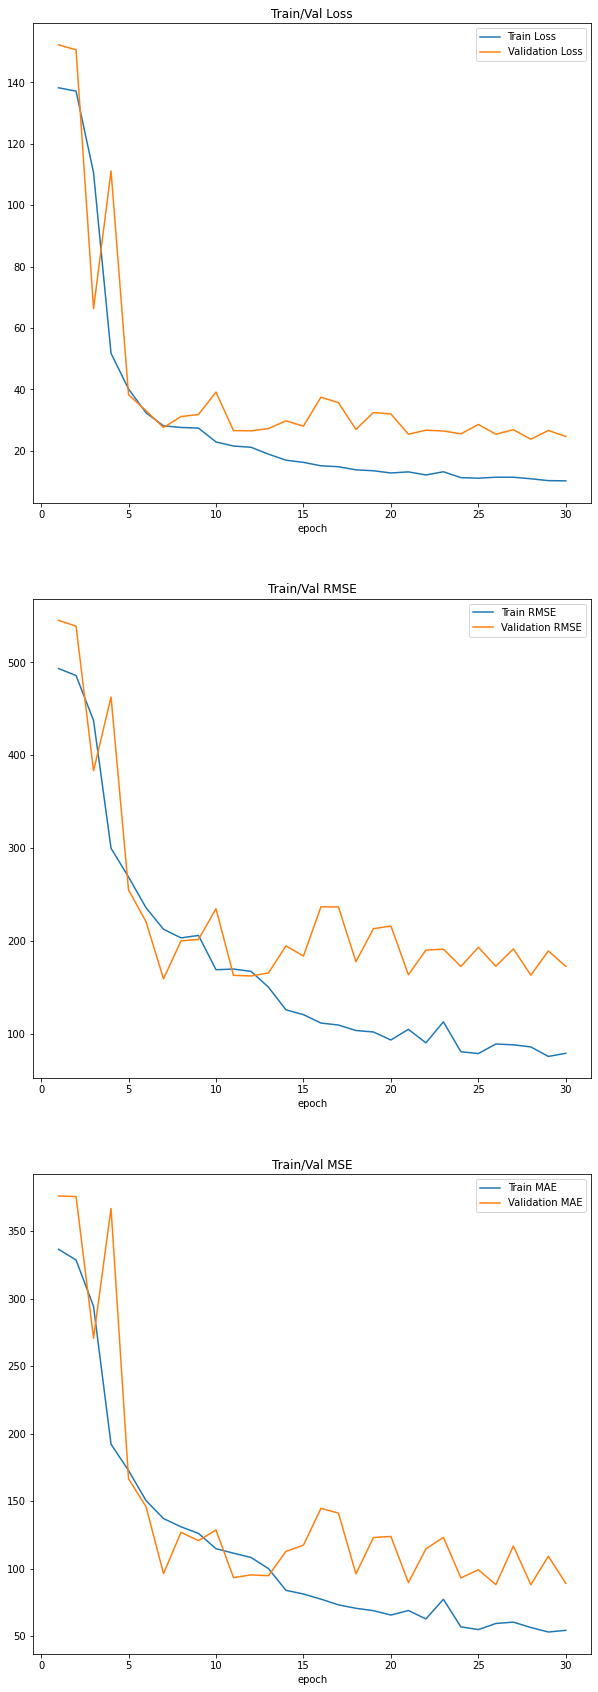

In [ ]:
history.plot()

In [ ]:
import os
import shutil

# make directory if not exist
dst = "/gdrive/MyDrive/csrnet_checkpoints2"
os.makedirs(dst, exist_ok=True)

# copy best and last checkpoints to drive
shutil.copyfile(checkpoint.best, os.path.join(dst, os.path.basename(checkpoint.best)))
shutil.copyfile(checkpoint.last, os.path.join(dst, os.path.basename(checkpoint.last)));

# Load best model and see results

In [47]:
model = CSRNet(pretrained_vgg=False)
model.load_state_dict(torch.load(checkpoint.best, device))
model = to_device(model, device)

In [48]:
_, eval_metrics = evaluate(model, val_dl, loss_fn)
print(f"val rmse: {eval_metrics['rmse']:0.4f} mae: {eval_metrics['mae']:0.4f}")

val rmse: 103.9021 mae: 62.0021


In [49]:
def get_random_sample(dataset):
  """
  gets random sample from dataset
  """
  index = np.random.randint(0, len(dataset))
  return dataset[index]

def batch_sample(image, target):
  """
  batches sample
  """
  image = image.unsqueeze(0)
  target = target.unsqueeze(0)
  return image, target

def visualize_predictions(images, gt_density_maps, pred_density_maps):
  """
  visualize predictions made by model
  """
  n = len(images)
  fig, axs = plt.subplots(nrows=n, ncols=1, figsize=(8, n*8))

  for i in range(n):
    image = images[i]
    image = image.transpose(1, 2, 0)

    dmap = gt_density_maps[i]
    pred_dmap = pred_density_maps[i]
    
    head_count = np.sum(dmap)
    pred_head_count = np.sum(pred_dmap)

    title = f"Head Count actual {head_count:.0f} pred {pred_head_count:.0f}"

    ax = axs.ravel()[i]

    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    image = ((image * std) + mean) * 255
    image = image.astype('uint8')
    ax.imshow(image, aspect='auto')
    ax.set_title(title)

    pred_dmap = cv2.resize(pred_dmap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

    ax.imshow(pred_dmap.clip(0, 1), cmap='jet', aspect='auto', alpha=0.33)

    ax.set_axis_off()

def predict_and_visualize(model, dataset, n=10):
  """
  makes n predictions and shows visualization for it
  """
  images = []
  gt_dmaps = []
  pred_dmaps = []

  for i in range(n):
    image, target = get_random_sample(dataset)
    
    image_batch, target_batch = batch_sample(image, target)

    image_batch = to_device(image_batch, device)

    model.eval()

    pred_dmap = model(image_batch)
    pred_dmap = pred_dmap[0]

    images.append(image.detach().cpu().numpy())
    gt_dmaps.append(target.detach().cpu().numpy())
    pred_dmaps.append(pred_dmap.detach().cpu().numpy())

  visualize_predictions(images, gt_dmaps, pred_dmaps)  

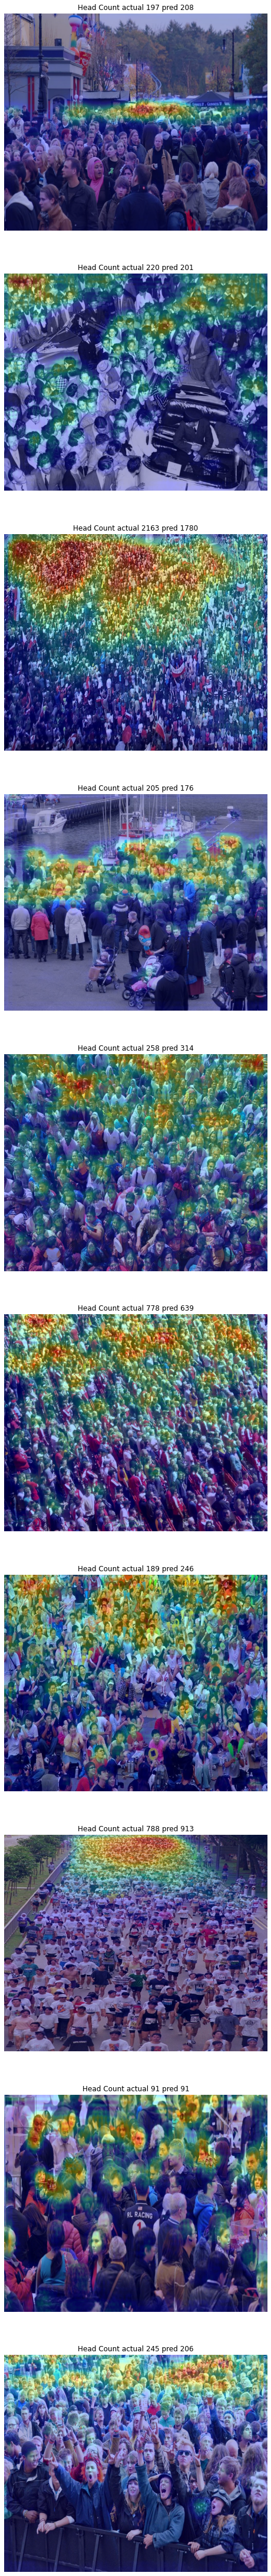

In [56]:
# plot some predications
predict_and_visualize(model, test_ds, n=10)

In [57]:
_, eval_metrics = evaluate(model, test_dl, loss_fn)
print(f"test rmse: {eval_metrics['rmse']:0.4f} mae: {eval_metrics['mae']:0.4f}")

test rmse: 113.5834 mae: 74.3890
